In [1]:
!pip install setfit[absa]
!pip install spacy
!spacy download en_core_web_lg
!spacy download en_core_web_sm
import wandb
!wandb login 6dda7c2887f0e415f189119bfdc66bcc57aa4b5d


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.6 MB/s eta 0:00:000:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 85.8 MB/s eta 0:00:00:00:01:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runti

Input file present using that now
Resuming from 5 completed folds (input checkpoint)...
Skipping Fold 1, already completed.
Skipping Fold 2, already completed.
Skipping Fold 3, already completed.
Skipping Fold 4, already completed.
Skipping Fold 5, already completed.
Validation Metrics for Each Fold:
+----+--------+-------------+----------+--------+--------+----------------+------------------------+
|    |   Fold |   Precision |   Recall |     F1 |    MCC |   Hamming Loss |   False Discovery Rate |
+====+========+=============+==========+========+========+================+========================+
|  0 |      1 |      0.8288 |   0.8056 | 0.817  | 0.7392 |         0.1125 |                 0.1714 |
+----+--------+-------------+----------+--------+--------+----------------+------------------------+
|  1 |      2 |      0.8302 |   0.8148 | 0.8224 | 0.743  |         0.1098 |                 0.1698 |
+----+--------+-------------+----------+--------+--------+----------------+-----------------

<Figure size 1200x600 with 0 Axes>

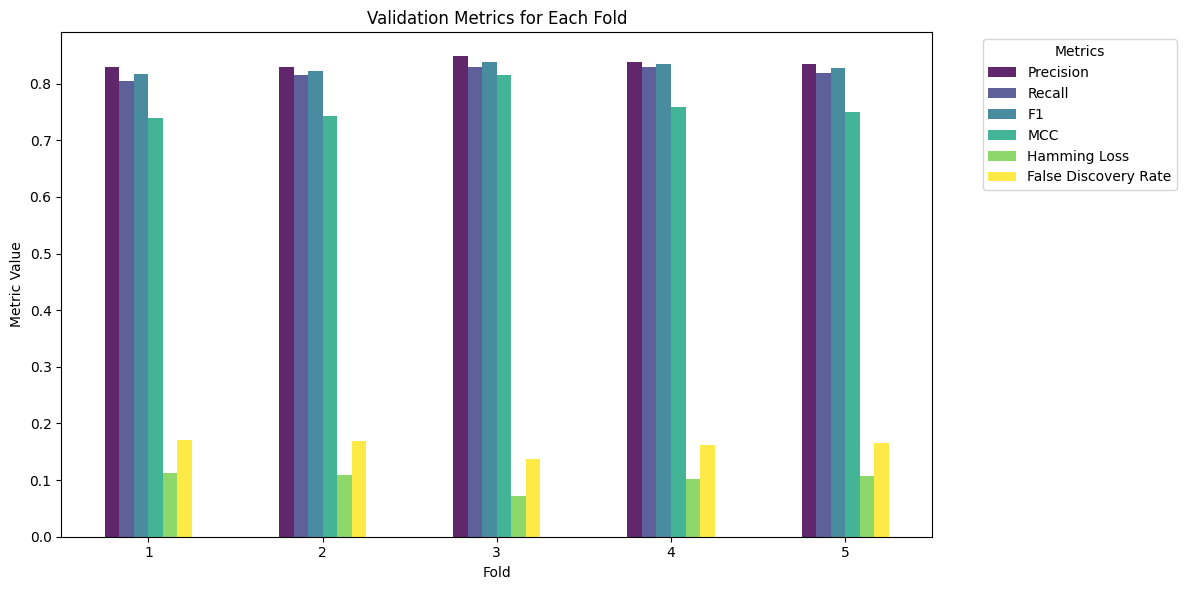

<Figure size 1000x500 with 0 Axes>

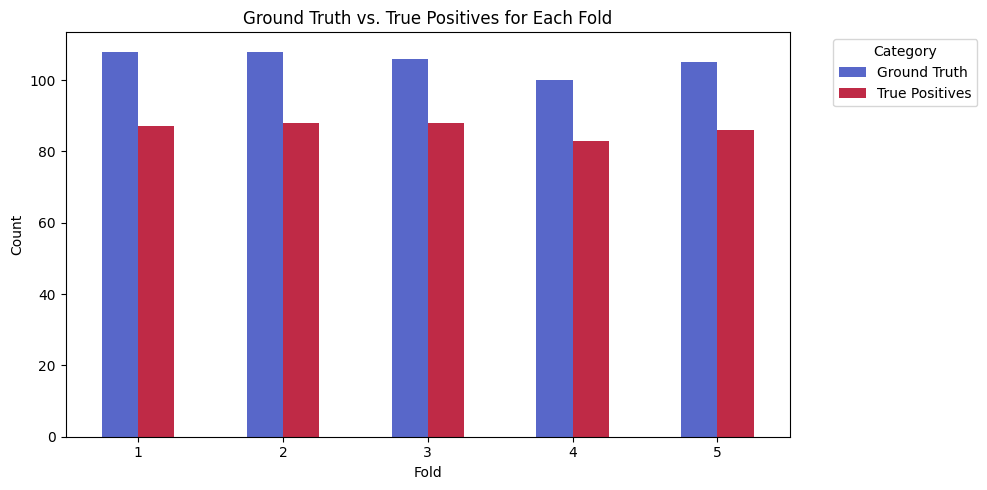

In [ ]:
import os
import shutil
import pandas as pd
import pickle
import numpy as np
import ast
from datasets import Dataset
from sklearn.model_selection import KFold
from setfit import AbsaTrainer, TrainingArguments
from transformers import EarlyStoppingCallback

def initialize_model():
    from setfit import AbsaModel
    model = AbsaModel.from_pretrained(
        "/kaggle/input/existingmodel1500/models/setfit-absa-model-aspect",
        "/kaggle/input/existingmodel1500/models/setfit-absa-model-polarity",
        spacy_model="en_core_web_lg",
    )
    return model


file_path = "/kaggle/input/2033merged2/merged_2033.csv"
df = pd.read_csv(file_path)

df = df.iloc[1550:2050]

if 'text' not in df.columns or 'span' not in df.columns:
    raise KeyError("Dataset must have 'text' (sentence) and 'span' (aspect term) columns.")

def count_aspect_occurrences(row):
    text = str(row['text'])
    aspect = str(row['span'])
    count = text.count(aspect)
    return count if count > 1 else 0

df['ordinal'] = df.apply(count_aspect_occurrences, axis=1)
dataset = Dataset.from_pandas(df)

kf = KFold(n_splits=5)
fold_metrics_list = []
fold_training_indices = {}


local_checkpoint = "fold_metrics.pkl"
input_checkpoint = "/kaggle/input/5foldgeneratedmetrics/fold_metrics.pkl"

if os.path.exists(local_checkpoint):
    with open(local_checkpoint, "rb") as f:
        saved_data = pickle.load(f)
        fold_metrics_list = saved_data.get("fold_metrics_list", [])
        fold_training_indices = saved_data.get("fold_training_indices", {})
    print("local file present, using that now")
    print(f"Resuming from {len(fold_metrics_list)} completed folds (local checkpoint)...")
elif os.path.exists(input_checkpoint):
    with open(input_checkpoint, "rb") as f:
        saved_data = pickle.load(f)
        fold_metrics_list = saved_data.get("fold_metrics_list", [])
        fold_training_indices = saved_data.get("fold_training_indices", {})
    print("Input file present using that now")
    print(f"Resuming from {len(fold_metrics_list)} completed folds (input checkpoint)...")
else:
    print("No previous fold data found. Starting fresh.")

dataset_path = "/kaggle/input/ordcrt5foldvaliddataset2"
def process_data(predict_file, model, fold_num, data_type="validation"):
    df_pred = pd.read_csv(predict_file)
    if "text" not in df_pred.columns:
        raise ValueError("The CSV file must have a column named 'text'.")
    texts = df_pred["text"].tolist()
    predictions = model.predict(texts)
    df_pred["predicted_label"] = predictions
    df_grouped = df_pred.groupby(["id", "text"], sort=False).apply(
        lambda x: x[["span", "predicted_label"]].values.tolist()
    ).reset_index()
    df_grouped.columns = ["id", "text", "predicted_aspect_sentiment_pairs"]
    grouped_file = f"grouped_predictions_{data_type}_fold_{fold_num}.csv"
    df_grouped.to_csv(grouped_file, index=False)
    return grouped_file

def format_predictions_file(grouped_file, actual_file, fold_num, data_type="validation"):
    df_pred = pd.read_csv(grouped_file)
    df_actual = pd.read_csv(actual_file)

    if "id" not in df_pred.columns or "id" not in df_actual.columns:
        raise ValueError("❌ Error: 'id' column is missing in one of the CSV files.")

    def format_predictions(row):
        predictions = row["predicted_aspect_sentiment_pairs"]
        row_id = row["id"]
        formatted = []
        try:
            predictions = ast.literal_eval(predictions)
            if not isinstance(predictions, list):
                raise ValueError
            for aspect_entry in predictions:
                if not isinstance(aspect_entry, list) or len(aspect_entry) < 2:
                    raise IndexError
                aspect = aspect_entry[0]
                if isinstance(aspect_entry[1], list) and len(aspect_entry[1]) > 0:
                    sentiment_data = aspect_entry[1][0]
                    if isinstance(sentiment_data, dict) and "polarity" in sentiment_data:
                        sentiment = sentiment_data["polarity"]
                        formatted.append([aspect, sentiment])
                    else:
                        raise IndexError
                elif isinstance(aspect_entry[1], str):
                    sentiment = aspect_entry[1]
                    formatted.append([aspect, sentiment])
                else:
                    raise IndexError
        except IndexError:
            print(f"⚠️ Skipping row ID {row_id} due to IndexError.")
            return None
        except Exception:
            print(f"⚠️ Skipping row ID {row_id} due to incorrect format.")
            return None
        return str(formatted).replace("'", '"')

    df_pred["formatted_predictions"] = df_pred.apply(format_predictions, axis=1)
    
    invalid_ids = df_pred[df_pred["formatted_predictions"].isna()]["id"].tolist()

    df_pred = df_pred.dropna(subset=["formatted_predictions"])
    df_actual = df_actual[~df_actual["id"].isin(invalid_ids)]

    formatted_file = f"formatted_predictions_{data_type}_fold_{fold_num}.csv"
    cleaned_actual_file = f"cleaned_actual_{data_type}_fold_{fold_num}.csv"

    df_pred.to_csv(formatted_file, index=False)
    df_actual.to_csv(cleaned_actual_file, index=False)

    return formatted_file, cleaned_actual_file

def compute_custom_metrics(formatted_file, actual_file):
    import pandas as pd
    import ast
    import numpy as np

    def safe_literal_eval(val):
        try:
            parsed_val = ast.literal_eval(val)
            if isinstance(parsed_val, list) and all(isinstance(i, list) and len(i) == 2 for i in parsed_val):
                return [tuple(i) for i in parsed_val]
        except (SyntaxError, ValueError):
            pass
        return np.nan

    df_pred = pd.read_csv(formatted_file)
    df_actual = pd.read_csv(actual_file)

    valid_ids = set(df_pred["id"].unique())
    df_actual = df_actual[df_actual["id"].isin(valid_ids)]

    df_pred["formatted_predictions"] = df_pred["formatted_predictions"].apply(safe_literal_eval)
    df_actual["aspect_sentiment_pairs"] = df_actual["aspect_sentiment_pairs"].apply(safe_literal_eval)

    pred_invalid_ids = df_pred.loc[df_pred["formatted_predictions"].isna(), "id"]
    actual_invalid_ids = df_actual.loc[df_actual["aspect_sentiment_pairs"].isna(), "id"]
    all_invalid_ids = set(pred_invalid_ids).union(set(actual_invalid_ids))

    df_pred = df_pred[~df_pred["id"].isin(all_invalid_ids)]
    df_actual = df_actual[~df_actual["id"].isin(all_invalid_ids)]

    df_pred.dropna(subset=["formatted_predictions"], inplace=True)
    df_actual.dropna(subset=["aspect_sentiment_pairs"], inplace=True)

    df_pred.reset_index(drop=True, inplace=True)
    df_actual.reset_index(drop=True, inplace=True)

    min_length = min(len(df_pred), len(df_actual))
    df_pred = df_pred.iloc[:min_length]
    df_actual = df_actual.iloc[:min_length]

    global_labels = sorted(set(
        tuple(pair) for pairs in df_pred["formatted_predictions"] + df_actual["aspect_sentiment_pairs"]
        for pair in pairs
    ))

    def pairs_to_vector(pairs, label_list):
        pair_set = set(pairs)
        return np.array([1 if label in pair_set else 0 for label in label_list])

    TP = FP = FN = TN = 0
    per_label_TP = {label: 0 for label in global_labels}
    per_label_FP = {label: 0 for label in global_labels}
    per_label_FN = {label: 0 for label in global_labels}

    ground_truth_count = 0 

    for idx in range(len(df_actual)):
        pred_vector = pairs_to_vector(df_pred.loc[idx, "formatted_predictions"], global_labels)
        true_vector = pairs_to_vector(df_actual.loc[idx, "aspect_sentiment_pairs"], global_labels)

        TP += np.sum((pred_vector == 1) & (true_vector == 1))
        FP += np.sum((pred_vector == 1) & (true_vector == 0))
        FN += np.sum((pred_vector == 0) & (true_vector == 1))
        TN += np.sum((pred_vector == 0) & (true_vector == 0))
        
        ground_truth_count += len(df_actual.loc[idx, "aspect_sentiment_pairs"])

        for i, label in enumerate(global_labels):
            per_label_TP[label] += int((pred_vector[i] == 1) and (true_vector[i] == 1))
            per_label_FP[label] += int((pred_vector[i] == 1) and (true_vector[i] == 0))
            per_label_FN[label] += int((pred_vector[i] == 0) and (true_vector[i] == 1))

    TP, FP, FN, TN = map(float, [TP, FP, FN, TN])

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = (2 * micro_precision * micro_recall) / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0.0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0.0

    mcc_num = (TP * TN - FP * FN)
    mcc_denom = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    MCC = mcc_num / mcc_denom if mcc_denom > 0 else 0.0
    hamming_loss = (FP + FN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0.0
    false_discovery_rate = FP / (TP + FP) if (TP + FP) > 0 else 0.0

    metrics = {
       "precision": precision,
       "recall": recall,
       "f1": f1,
       "mcc": MCC,
       "TP": TP,
       "FP": FP,
       "FN": FN,
       "TN": TN,
       "ground_truth": ground_truth_count,
       "hamming_loss": hamming_loss,
       "false_discovery_rate": false_discovery_rate
    }
    return metrics


for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    if fold < len(fold_metrics_list):
        print(f"Skipping Fold {fold+1}, already completed.")
        continue

    print(f"Starting Fold {fold+1}...")
    train_dataset = dataset.select(train_idx)
    eval_dataset = dataset.select(val_idx)
    fold_training_indices[fold] = train_idx

    args = TrainingArguments(
        output_dir=f"models/fold_{fold+1}",
        num_epochs=7,
        use_amp=True,
        batch_size=128,
        eval_strategy="steps",
        eval_steps=50000,
        save_steps=50000,
        load_best_model_at_end=True,
      )
    
    model = initialize_model() 
    class AbsaTrainer1(AbsaTrainer):
        def log(self, logs: dict) -> None:
       
            pass
    trainer = AbsaTrainer1(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    )
    trainer.train()

    val_predict_file = f"{dataset_path}/val_predict_fold_{fold+1}.csv"
    val_actual_file = f"{dataset_path}/val_actual_fold_{fold+1}.csv"
    
    grouped_val_file = process_data(val_predict_file, model, fold+1, data_type="validation")
    formatted_val_file, cleaned_val_actual_file = format_predictions_file(grouped_val_file, val_actual_file, fold+1, data_type="validation")
    val_metrics = compute_custom_metrics(formatted_val_file, cleaned_val_actual_file)

    print(f"Fold {fold+1} Validation Metrics:")
    for key, value in val_metrics.items():
        print(f"{key}: {value:.4f}")


    fold_data = {
        "fold": fold,
        "val_metrics": val_metrics
    }
    fold_metrics_list.append(fold_data)
    
    with open("fold_metrics.pkl", "wb") as f:
        pickle.dump({"fold_metrics_list": fold_metrics_list, "fold_training_indices": fold_training_indices}, f)
   
    shutil.make_archive("fold_metrics", "zip", ".", "fold_metrics.pkl")
    
    print(f"Fold {fold+1} completed and saved.\n")

import pandas as pd
import numpy as np
import pickle
from tabulate import tabulate  

fold_metrics_data = []
fold_ground_truth_data = []


for fd in fold_metrics_list:  
    m = fd["val_metrics"]  
    
    fold_row = {
        "Fold": fd["fold"],
        "Precision": m["precision"],
        "Recall": m["recall"],
        "F1": m["f1"],
        "MCC": m["mcc"],
        "Hamming Loss": m["hamming_loss"],
        "False Discovery Rate": m["false_discovery_rate"]
    }
    fold_metrics_data.append(fold_row)
    
    
    ground_truth_row = {
        "Fold": fd["fold"],
        "Ground Truth": m["ground_truth"],
        "True Positives": m["TP"]
    }
    fold_ground_truth_data.append(ground_truth_row)
    

df_fold_metrics = pd.DataFrame(fold_metrics_data)
df_ground_truth = pd.DataFrame(fold_ground_truth_data)


table_format = "grid"  

print("Validation Metrics for Each Fold:")
print(tabulate(df_fold_metrics, headers="keys", tablefmt=table_format))

print("\nGround Truth and True Positives for Each Fold:")
print(tabulate(df_ground_truth, headers="keys", tablefmt=table_format))


avg_metrics = {
    "Precision": np.mean(df_fold_metrics["Precision"]),
    "Recall": np.mean(df_fold_metrics["Recall"]),
    "F1": np.mean(df_fold_metrics["F1"]),
    "MCC": np.mean(df_fold_metrics["MCC"]),
    "Hamming Loss": np.mean(df_fold_metrics["Hamming Loss"]),
    "False Discovery Rate": np.mean(df_fold_metrics["False Discovery Rate"])
}


print("\nAverage Validation Metrics across Folds:")
print(tabulate([avg_metrics], headers="keys", tablefmt=table_format))

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df_fold_metrics.set_index("Fold")[["Precision", "Recall", "F1", "MCC", "Hamming Loss", "False Discovery Rate"]].plot(
    kind="bar", colormap="viridis", alpha=0.85, figsize=(12, 6)
)
plt.title("Validation Metrics for Each Fold")
plt.xlabel("Fold")
plt.ylabel("Metric Value")
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc="upper left")  # Move legend outside
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
df_ground_truth.set_index("Fold").plot(kind="bar", colormap="coolwarm", alpha=0.85, figsize=(10, 5))
plt.title("Ground Truth vs. True Positives for Each Fold")
plt.xlabel("Fold")
plt.ylabel("Count")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")  # Move legend outside
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [3]:
import shutil
shutil.make_archive("/kaggle/working/fullfinalmodel", "zip", "/kaggle/working", "models")
shutil.make_archive("/kaggle/working/setfitaspect", "zip", "/kaggle/working/models", "setfit-absa-final-aspect")
shutil.make_archive("/kaggle/working/setfitpolarity", "zip", "/kaggle/working/models", "setfit-absa-final-polarity")

print("Zipping complete! Download from /kaggle/working/my_models.zip and /kaggle/working/new_models.zip")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Zipping complete! Download from /kaggle/working/my_models.zip and /kaggle/working/new_models.zip
